<a href="https://colab.research.google.com/github/samohtwal/Bayesian-Personalized-Ranking/blob/main/Bayesian_Personalized_Ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from itertools import islice
from google.colab import files
import os
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
global data_user_column_name
data_user_column_name = 'user_id'

global data_item_column_name
data_item_column_name = 'item_id'

global data_group_by_user_id_dictionary_key
data_group_by_user_id_dictionary_key = 'Data Group By User ID'

global data_group_by_item_id_dictionary_key
data_group_by_item_id_dictionary_key = 'Data Group By Item ID'

global user_latent_factor_matrix_dictionary_key
user_latent_factor_matrix_dictionary_key = 'User Latent Factor Matrix'

global item_latent_factor_matrix_dictionary_key
item_latent_factor_matrix_dictionary_key = 'Item Latent Factor Matrix'

global recommendation_number_dictionary_key
recommendation_number_dictionary_key = 'Recommendation Number'

global true_positive_rate_dictionary_key
true_positive_rate_dictionary_key = 'True Positive Rate'

global false_positive_rate_dictionary_key
false_positive_rate_dictionary_key = 'False Positive Rate'

global precision_dictionary_key
precision_dictionary_key = 'Precision'

global accuracy_dictionary_key
accuracy_dictionary_key = 'Accuracy'

global working_file_path
working_file_path = '/content/working/'

global user_latent_factor_matrix_file_name_base
user_latent_factor_matrix_file_name_base = 'user_latent_factor_matrix'

global item_latent_factor_matrix_file_name_base
item_latent_factor_matrix_file_name_base = 'item_latent_factor_matrix'

global root_mean_square_error_file_name_base
root_mean_square_error_file_name_base = 'root_mean_square_error'

global precision_file_name_base
precision_file_name_base = 'precision'

global csv_file_extension
csv_file_extension = '.csv'

global training_data_url
training_data_url = 'https://raw.githubusercontent.com/samohtwal/Bayesian-Personalized-Ranking/main/data/train.csv'

global validation_data_url
validation_data_url = 'https://raw.githubusercontent.com/samohtwal/Bayesian-Personalized-Ranking/main/data/vali.csv'

global testing_data_url
testing_data_url = 'https://raw.githubusercontent.com/samohtwal/Bayesian-Personalized-Ranking/main/data/test.csv'

In [4]:
class DataHelper:

    def load_data_dictionary(self, data_url):

        column_names = [data_user_column_name, data_item_column_name]
        raw_data = pd.read_csv(data_url, names = column_names, header=0)

        data_group_by_user_id = raw_data.groupby(data_user_column_name)[data_item_column_name].apply(list).reset_index(name=data_item_column_name).sort_values(by=[data_user_column_name])
        data_group_by_item_id = raw_data.groupby(data_item_column_name)[data_user_column_name].apply(list).reset_index(name=data_user_column_name).sort_values(by=[data_item_column_name])

        data_dictionary = {
            data_group_by_user_id_dictionary_key: data_group_by_user_id, 
            data_group_by_item_id_dictionary_key: data_group_by_item_id
        }

        return data_dictionary

In [5]:
class BayseianPersonalizedRankingModel:

    def __init__(self, random_seed, n_latent_factor, n_batch, learning_rate, regularization_constant):
        
        self.random_seed = random_seed
        self.n_latent_factor = n_latent_factor
        self.n_batch = n_batch
        self.learning_rate = learning_rate
        self.regularization_constant = regularization_constant
        
        self.training_data_dictionary = {}
        self.latent_factor_matrix_dictionary = {}
        self.root_mean_square_errors = []
        self.root_mean_square_error = 0

        self.elapsed_time = 0
        self.evaluation_dictionary = {}

        self.validation_data_dictionary = {}
        self.testing_data_dictionary = {}
    
    def fit(self):

        start_time = datetime.now()

        training_data_dictionary = self.training_data_dictionary

        training_data_group_by_user_id = training_data_dictionary[data_group_by_user_id_dictionary_key]
        training_data_group_by_item_id = training_data_dictionary[data_group_by_item_id_dictionary_key]

        n_user = len(training_data_group_by_user_id[data_user_column_name])
        n_item = len(training_data_group_by_item_id[data_item_column_name])

        rstate = np.random.RandomState(self.random_seed)

        user_latent_factor_matrix = rstate.normal(size = (n_user, self.n_latent_factor))
        item_latent_factor_matrix = rstate.normal(size = (n_item, self.n_latent_factor))

        user_item_rating_matrix = self._create_user_item_rating_matrix(training_data_group_by_user_id, training_data_group_by_item_id)

        user_latent_factor_matrixes = []
        item_latent_factor_matrixes = []
        root_mean_square_errors = []

        is_converge = True
        index = 0
        while is_converge:
            
            sample_latent_factor_matrix_row_indexes = self._create_sample_latent_factor_matrix_row_indexes(training_data_group_by_user_id, training_data_group_by_item_id)
            sample_user_id_indexes, sample_positive_item_id_indexes, sample_negative_item_id_indexes = sample_latent_factor_matrix_row_indexes
            user_latent_factor_matrix, item_latent_factor_matrix = self._update_sample_latent_factor_matrix_rows(user_latent_factor_matrix, item_latent_factor_matrix, sample_user_id_indexes, sample_positive_item_id_indexes, sample_negative_item_id_indexes)
            
            sum_of_square_error = np.sum((user_item_rating_matrix - self._predict(user_latent_factor_matrix, item_latent_factor_matrix))**2)
            root_mean_square_error = round(np.sqrt((sum_of_square_error / n_user * n_item)), 0)

            user_latent_factor_matrixes.append(user_latent_factor_matrix)
            item_latent_factor_matrixes.append(item_latent_factor_matrix)
            root_mean_square_errors.append(root_mean_square_error)
            
            print('debug - learning_rate:', self.learning_rate, 
                    'regularization_constant:', self.regularization_constant, 
                    'n_batch:', self.n_batch, 
                    'n_latent_factor:', self.n_latent_factor, end='\n')
            print('debug - iteration:', index+1, 'root_mean_square_error:', root_mean_square_error, end='\n')
            print('', end='\n')
            
            if (index >= 3
                and root_mean_square_errors[index] >= root_mean_square_errors[index-1]
                and root_mean_square_errors[index-1] >= root_mean_square_errors[index-2]
                and root_mean_square_errors[index-2] >= root_mean_square_errors[index-3]):
                is_converge = False

            index = index + 1

        latent_factor_matrix_dictionary = {
            user_latent_factor_matrix_dictionary_key: user_latent_factor_matrixes[index-3], 
            item_latent_factor_matrix_dictionary_key: item_latent_factor_matrixes[index-3]
        }

        root_mean_square_error = root_mean_square_errors[index-3]

        end_time = datetime.now()
        elapsed_time = end_time - start_time

        self.latent_factor_matrix_dictionary = latent_factor_matrix_dictionary
        self.root_mean_square_errors = root_mean_square_errors
        self.root_mean_square_error = root_mean_square_error

        self.elapsed_time = elapsed_time

        return None
    
    def _create_user_item_rating_matrix(self, training_data_group_by_user_id, training_data_group_by_item_id):

        n_user = len(training_data_group_by_user_id[data_user_column_name])
        n_item = len(training_data_group_by_item_id[data_item_column_name])

        user_ids = training_data_group_by_user_id[data_user_column_name].tolist()
        item_ids = training_data_group_by_item_id[data_item_column_name].tolist()

        user_item_rating_matrix = np.zeros((n_user, n_item), dtype = np.int64)
        for user_id_index, user_id in enumerate(user_ids):
            item_id_indexes = np.where(np.isin(training_data_group_by_user_id.iloc[user_id_index][data_item_column_name],item_ids))[0]
            for item_id_index in item_id_indexes:
                user_item_rating_matrix[user_id_index, item_id_index] = 1

        return user_item_rating_matrix

    def _create_sample_latent_factor_matrix_row_indexes(self, training_data_group_by_user_id, training_data_group_by_item_id):

        n_user = len(training_data_group_by_user_id[data_user_column_name])
        n_item = len(training_data_group_by_item_id[data_item_column_name])

        item_ids = training_data_group_by_item_id[data_item_column_name].tolist()

        sample_user_id_indexes = np.random.choice(n_user, size = self.n_batch, replace = False)
        sample_positive_item_id_indexes = np.zeros(self.n_batch, dtype = np.int64)
        sample_negative_item_id_indexes = np.zeros(self.n_batch, dtype = np.int64)

        for index, sampled_user_id_index in enumerate(sample_user_id_indexes):
            possible_positive_item_ids = training_data_group_by_user_id.iloc[sampled_user_id_index][data_item_column_name]
            possible_negative_item_ids = list(set(item_ids).difference(possible_positive_item_ids))
            sample_positive_item_id = np.random.choice(possible_positive_item_ids)
            sample_negative_item_id = np.random.choice(possible_negative_item_ids)
            sample_positive_item_id_indexes[index] = item_ids.index(sample_positive_item_id)
            sample_negative_item_id_indexes[index] = item_ids.index(sample_negative_item_id)

        return sample_user_id_indexes, sample_positive_item_id_indexes, sample_negative_item_id_indexes

    def _update_sample_latent_factor_matrix_rows(self, user_latent_factor_matrix, item_latent_factor_matrix, sample_user_id_indexes, sample_positive_item_id_indexes, sample_negative_item_id_indexes):

        sample_user_latent_factor_matrix_tuple = user_latent_factor_matrix[sample_user_id_indexes]
        sample_item_latent_factor_matrix_positive_item_tuple = item_latent_factor_matrix[sample_positive_item_id_indexes]
        sample_item_latent_factor_matrix_negative_item_tuple = item_latent_factor_matrix[sample_negative_item_id_indexes]

        r_uij = np.sum(sample_user_latent_factor_matrix_tuple * (sample_item_latent_factor_matrix_positive_item_tuple - sample_item_latent_factor_matrix_negative_item_tuple), axis = 1)
        sigmoid = np.exp(-r_uij) / (1.0 + np.exp(-r_uij))
        sigmoid_tiled = np.tile(sigmoid, (self.n_latent_factor, 1)).T

        gradient_user = sigmoid_tiled * (sample_item_latent_factor_matrix_negative_item_tuple - sample_item_latent_factor_matrix_positive_item_tuple) + self.regularization_constant * sample_user_latent_factor_matrix_tuple
        gradient_positive_item = sigmoid_tiled * -sample_user_latent_factor_matrix_tuple + self.regularization_constant * sample_item_latent_factor_matrix_positive_item_tuple
        gradient_negative_item = sigmoid_tiled * sample_user_latent_factor_matrix_tuple + self.regularization_constant * sample_item_latent_factor_matrix_negative_item_tuple

        user_latent_factor_matrix[sample_user_id_indexes] -= self.learning_rate * gradient_user
        item_latent_factor_matrix[sample_positive_item_id_indexes] -= self.learning_rate * gradient_positive_item
        item_latent_factor_matrix[sample_negative_item_id_indexes] -= self.learning_rate * gradient_negative_item

        return user_latent_factor_matrix, item_latent_factor_matrix
    
    def recommend(self, n_best_recommendation, evaluation_mode):

        if evaluation_mode == 'validation':
            testing_data_dictionary = bayseian_personalized_ranking_model.validation_data_dictionary
        else:
            testing_data_dictionary = bayseian_personalized_ranking_model.testing_data_dictionary
            
        training_data_dictionary = self.training_data_dictionary
        latent_factor_matrix_dictionary = self.latent_factor_matrix_dictionary

        testing_data_group_by_user_id = testing_data_dictionary[data_group_by_user_id_dictionary_key]

        n_user = len(testing_data_group_by_user_id[data_user_column_name])
        user_ids = user_ids = testing_data_group_by_user_id[data_user_column_name].tolist()

        recommendation_user_ids = []
        recommendation_item_ids = []
        for user_id in user_ids:
            best_recommendition_item_ids = self.recommend_user(user_id, n_best_recommendation)

            print('debug - n_best_recommendation:', n_best_recommendation, 
                    'learning_rate:', self.learning_rate,
                    'regularization_constant:', self.regularization_constant, 
                    'n_batch:', self.n_batch, 
                    'n_latent_factor:', self.n_latent_factor,
                    end='\n')
            print('debug - user_id:', user_id, 'best_recommendition_item_ids:', best_recommendition_item_ids, end='\n')
            print('', end='\n')

            for item_id in best_recommendition_item_ids:
                recommendation_user_ids.append(user_id)
                recommendation_item_ids.append(item_id)

        data = {'user_id': recommendation_user_ids, 'item_id': recommendation_item_ids}
        recommendation_data = pd.DataFrame.from_dict(data)

        recommendation_data_group_by_user_id = recommendation_data.groupby(data_user_column_name)[data_item_column_name].apply(list).reset_index(name=data_item_column_name).sort_values(by=[data_user_column_name])
        recommendation_data_group_by_item_id = recommendation_data.groupby(data_item_column_name)[data_user_column_name].apply(list).reset_index(name=data_user_column_name).sort_values(by=[data_item_column_name])

        recommendation_data_dictionary = {
            data_group_by_user_id_dictionary_key: recommendation_data_group_by_user_id, 
            data_group_by_item_id_dictionary_key: recommendation_data_group_by_item_id
        }

        return recommendation_data_dictionary

    def recommend_user(self, user_id, n_best_recommendation):

        training_data_dictionary = self.training_data_dictionary
        latent_factor_matrix_dictionary = self.latent_factor_matrix_dictionary

        training_data_group_by_user_id = training_data_dictionary[data_group_by_user_id_dictionary_key]
        training_data_group_by_item_id = training_data_dictionary[data_group_by_item_id_dictionary_key]

        user_latent_factor_matrix = latent_factor_matrix_dictionary[user_latent_factor_matrix_dictionary_key]
        item_latent_factor_matrix = latent_factor_matrix_dictionary[item_latent_factor_matrix_dictionary_key]

        user_ids = training_data_group_by_user_id[data_user_column_name].tolist()
        item_ids = training_data_group_by_item_id[data_item_column_name].tolist()

        n_item = len(training_data_group_by_item_id[data_item_column_name])

        user_index = user_ids.index(user_id)

        scores = self._predict_user(user_latent_factor_matrix, item_latent_factor_matrix, user_index)

        item_score_dictionary = {item_ids[i]: scores[i] for i in range(len(item_ids))}

        item_score_dictionary = dict(sorted(item_score_dictionary.items(), key=lambda item: item[1], reverse=True))
        best_recommendition_item_dictionary = dict(islice(item_score_dictionary.items(), n_best_recommendation))
        best_recommendition_item_ids = list(best_recommendition_item_dictionary.keys())

        return best_recommendition_item_ids

    def _predict(self, user_latent_factor_matrix, item_latent_factor_matrix):
        return user_latent_factor_matrix.dot(item_latent_factor_matrix.T)

    def _predict_user(self, user_latent_factor_matrix, item_latent_factor_matrix, user_index):
        return user_latent_factor_matrix[user_index].dot(item_latent_factor_matrix.T)

In [13]:
class ModelAnalyzerHelper:

    def plot_elapsed_time_chart(self, bayseian_personalized_ranking_models):

        dictionarys = []
        for bayseian_personalized_ranking_model in bayseian_personalized_ranking_models:

            match_index = -1
            for index, dictionary in enumerate(dictionarys):
                if (dictionary['Learning Rate'] == bayseian_personalized_ranking_model.learning_rate
                    and dictionary['Regularization Constant'] == bayseian_personalized_ranking_model.regularization_constant
                    and dictionary['Number of Latent Factor'] == bayseian_personalized_ranking_model.n_latent_factor):
                    match_index = index
            
            if match_index != -1:
                dictionarys[match_index]['Elapsed Times'].append(bayseian_personalized_ranking_model.elapsed_time.total_seconds())
                dictionarys[match_index]['Batch Sizes'].append(bayseian_personalized_ranking_model.n_batch)
            else:
                dictionarys.append({'Learning Rate' : bayseian_personalized_ranking_model.learning_rate, 
                    'Regularization Constant' : bayseian_personalized_ranking_model.regularization_constant,
                    'Number of Latent Factor' : bayseian_personalized_ranking_model.n_latent_factor,
                    'Elapsed Times' : [bayseian_personalized_ranking_model.elapsed_time.total_seconds()],
                    'Batch Sizes' : [bayseian_personalized_ranking_model.n_batch]})

        for dictionary in dictionarys:
            x = dictionary['Batch Sizes']
            y = dictionary['Elapsed Times']
            label = 'Learning Rate = ' + str(dictionary['Learning Rate']) \
                + ' Regularization Constant = ' + str(dictionary['Regularization Constant']) \
                + ' Number of Latent Factor = ' + str(dictionary['Number of Latent Factor'])
            plt.plot(x, y, label=label)
        
        plt.xlabel("Batch Size")
        plt.ylabel("Elapsed Time")
        plt.title("Elapsed Time / Batch Size")
        plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
        plt.show()

        return None

    def plot_receiver_operating_characteristic_chart(self, bayseian_personalized_ranking_models):

        for bayseian_personalized_ranking_model in bayseian_personalized_ranking_models:
            x = bayseian_personalized_ranking_model.evaluation_dictionary[false_positive_rate_dictionary_key]
            y = bayseian_personalized_ranking_model.evaluation_dictionary[true_positive_rate_dictionary_key]
            label = 'Learning Rate = ' + str(bayseian_personalized_ranking_model.learning_rate) \
                + ' Regularization Constant = ' + str(bayseian_personalized_ranking_model.regularization_constant) \
                + ' Batch Size = ' + str(bayseian_personalized_ranking_model.n_batch) \
                + ' Number of Latent Factor = ' + str(bayseian_personalized_ranking_model.n_latent_factor)
            plt.plot(x, y, label=label)

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("True Positive Rate / False Positive Rate")
        plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
        plt.show()

        return None


    def plot_precision_chart(self, bayseian_personalized_ranking_models):

        for bayseian_personalized_ranking_model in bayseian_personalized_ranking_models:
            x = bayseian_personalized_ranking_model.evaluation_dictionary[recommendation_number_dictionary_key]
            y = bayseian_personalized_ranking_model.evaluation_dictionary[precision_dictionary_key]
            label = 'Learning Rate = ' + str(bayseian_personalized_ranking_model.learning_rate) \
                + ' Regularization Constant = ' + str(bayseian_personalized_ranking_model.regularization_constant) \
                + ' Batch Size = ' + str(bayseian_personalized_ranking_model.n_batch) \
                + ' Number of Latent Factor = ' + str(bayseian_personalized_ranking_model.n_latent_factor)
            plt.plot(x, y, label=label)

        plt.xlabel("Recommendation Item Number")
        plt.ylabel("Precision")
        plt.title("Precision / Recommendation Item Number")
        plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
        plt.show()

        return None

    def plot_accuracy_chart(self, bayseian_personalized_ranking_models):

        for bayseian_personalized_ranking_model in bayseian_personalized_ranking_models:
            x = bayseian_personalized_ranking_model.evaluation_dictionary[recommendation_number_dictionary_key]
            y = bayseian_personalized_ranking_model.evaluation_dictionary[accuracy_dictionary_key]
            label = 'Learning Rate = ' + str(bayseian_personalized_ranking_model.learning_rate) \
                + ' Regularization Constant = ' + str(bayseian_personalized_ranking_model.regularization_constant) \
                + ' Batch Size = ' + str(bayseian_personalized_ranking_model.n_batch) \
                + ' Number of Latent Factor = ' + str(bayseian_personalized_ranking_model.n_latent_factor)
            plt.plot(x, y, label=label)

        plt.xlabel("Recommendation Item Number")
        plt.ylabel("Accuracy")
        plt.title("Accuracy / Recommendation Item Number")
        plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
        plt.show()

        return None

    def plot_root_mean_square_error_chart(self, bayseian_personalized_ranking_models):

        for index, bayseian_personalized_ranking_model in enumerate(bayseian_personalized_ranking_models):
            x = range(len(bayseian_personalized_ranking_model.root_mean_square_errors))
            y = bayseian_personalized_ranking_model.root_mean_square_errors
            label = 'Learning Rate = ' + str(bayseian_personalized_ranking_model.learning_rate) \
                + ' Regularization Constant = ' + str(bayseian_personalized_ranking_model.regularization_constant) \
                + ' Batch Size = ' + str(bayseian_personalized_ranking_model.n_batch) \
                + ' Number of Latent Factor = ' + str(bayseian_personalized_ranking_model.n_latent_factor)
            plt.plot(x, y, label=label)

        plt.xlabel("Iteration")
        plt.ylabel("Root Mean Square Error")
        plt.title("Root Mean Square Error / Iteration")
        plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
        plt.show()

        return None
    
    def evaluate(self, bayseian_personalized_ranking_model, recommendation_data_dictionary, evaluation_mode):

        if evaluation_mode == 'validation':
            testing_data_dictionary = bayseian_personalized_ranking_model.validation_data_dictionary
        else:
            testing_data_dictionary = bayseian_personalized_ranking_model.testing_data_dictionary

        testing_data_group_by_user_id = testing_data_dictionary[data_group_by_user_id_dictionary_key]
        testing_user_ids = testing_data_group_by_user_id[data_user_column_name].tolist()

        testing_data_group_by_item_id = testing_data_dictionary[data_group_by_item_id_dictionary_key]
        testing_item_ids = testing_data_group_by_item_id[data_item_column_name].tolist()

        recommendation_data_group_by_user_id = recommendation_data_dictionary[data_group_by_user_id_dictionary_key]
        recommendation_user_ids = recommendation_data_group_by_user_id[data_user_column_name].tolist()

        n_true_positive = 0
        n_false_positive = 0
        n_true_negative = 0
        n_false_negative = 0

        for index, recommendation_user_id in enumerate(recommendation_user_ids):

            n_user_true_positive = 0
            n_user_false_positive = 0
            n_user_true_negative = 0
            n_user_false_negative = 0
            
            testing_user_index = testing_user_ids.index(recommendation_user_id)
            positive_testing_item_ids = testing_data_group_by_user_id.iloc[testing_user_index][data_item_column_name]
            negative_testing_item_ids = list(set(testing_item_ids).difference(positive_testing_item_ids))
            positive_predition_item_ids = recommendation_data_group_by_user_id.iloc[index][data_item_column_name]
            negative_predition_item_ids = list(set(testing_item_ids).difference(positive_predition_item_ids))

            for positive_predition_item_id in positive_predition_item_ids:
                if positive_predition_item_id in positive_testing_item_ids: n_user_true_positive = n_user_true_positive + 1
                if positive_predition_item_id not in positive_testing_item_ids: n_user_false_positive = n_user_false_positive + 1

            for negative_predition_item_id in negative_predition_item_ids:
                if negative_predition_item_id in negative_testing_item_ids: n_user_true_negative = n_user_true_negative + 1
                if negative_predition_item_id not in negative_testing_item_ids: n_user_false_negative = n_user_false_negative + 1

            print('debug - n_best_recommendation:', n_best_recommendation, 
                    'learning_rate:', bayseian_personalized_ranking_model.learning_rate,
                    'regularization_constant:', bayseian_personalized_ranking_model.regularization_constant, 
                    'n_batch:', bayseian_personalized_ranking_model.n_batch, 
                    'n_latent_factor:', bayseian_personalized_ranking_model.n_latent_factor,
                    end='\n')

            print('debug - recommendation_user_id:', recommendation_user_id, 
                  'n_user_true_positive:', n_user_true_positive,
                  'n_user_false_positive:', n_user_false_positive, 
                  'n_user_true_negative:', n_user_true_negative,
                  'n_user_false_negative:', n_user_false_negative,
                  end='\n')
            print('', end='\n')

            n_true_positive = n_true_positive + n_user_true_positive
            n_false_positive = n_false_positive + n_user_false_positive
            n_true_negative = n_true_negative + n_user_true_negative
            n_false_negative = n_false_negative + n_user_false_negative

        print('debug - n_true_positive:', n_true_positive,
              'n_false_positive:', n_false_positive,
              'n_true_negative:', n_true_negative,
              'n_false_negative:', n_false_negative,
              end='\n')
        print('', end='\n')

        true_positive_rate = n_true_positive / (n_true_positive + n_false_negative)
        false_positive_rate = n_false_positive / (n_false_positive + n_true_negative)

        precision = n_true_positive / (n_true_positive + n_false_positive)
        accuracy = (n_true_positive + n_true_negative) / (n_true_positive + n_false_positive + n_true_negative + n_false_negative)

        return true_positive_rate, false_positive_rate, precision, accuracy

Streaming output truncated to the last 5000 lines.
debug - iteration: 324 root_mean_square_error: 1381.0

debug - learning_rate: 0.2 regularization_constant: 0.1 n_batch: 1000 n_latent_factor: 100
debug - iteration: 1 root_mean_square_error: 30273.0

debug - learning_rate: 0.2 regularization_constant: 0.1 n_batch: 1000 n_latent_factor: 100
debug - iteration: 2 root_mean_square_error: 29943.0

debug - learning_rate: 0.2 regularization_constant: 0.1 n_batch: 1000 n_latent_factor: 100
debug - iteration: 3 root_mean_square_error: 29623.0

debug - learning_rate: 0.2 regularization_constant: 0.1 n_batch: 1000 n_latent_factor: 100
debug - iteration: 4 root_mean_square_error: 29289.0

debug - learning_rate: 0.2 regularization_constant: 0.1 n_batch: 1000 n_latent_factor: 100
debug - iteration: 5 root_mean_square_error: 28966.0

debug - learning_rate: 0.2 regularization_constant: 0.1 n_batch: 1000 n_latent_factor: 100
debug - iteration: 6 root_mean_square_error: 28647.0

debug - learning_rate: 0

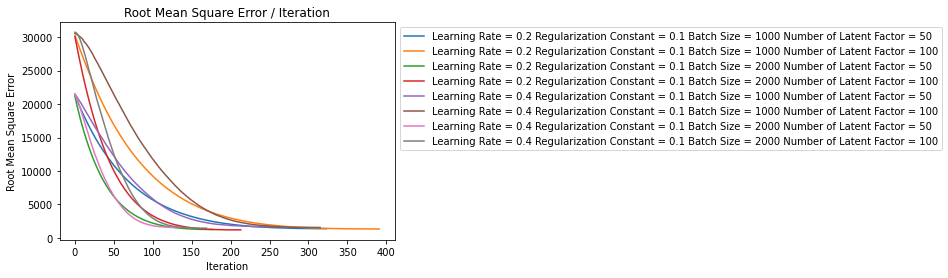

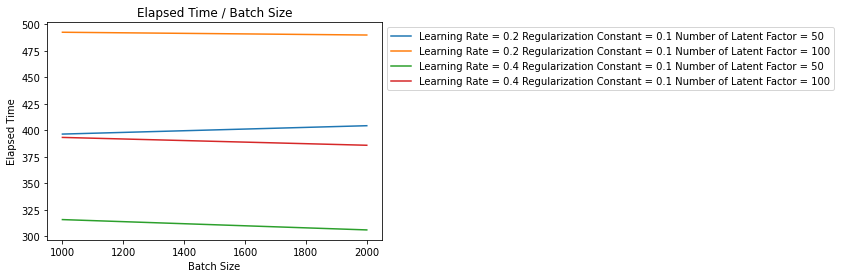

In [9]:
# train model

training_data_dictionary = DataHelper().load_data_dictionary(training_data_url)
n_user = len(training_data_dictionary[data_group_by_user_id_dictionary_key][data_user_column_name])

bayseian_personalized_ranking_parameters = []

learning_rate_start = 0.2
learning_rate_step = 0.2
learning_rate_stop = 0.4 + 0.05

n_batch_start = 1000
n_batch_step = 1000
n_batch_stop = 2000 + 1

regularization_constant_start = 0.1
regularization_constant_step = 0.5
regularization_constant_stop = 0.2 + 0.05

n_latent_factor_start = 50
n_latent_factor_step = 50
n_latent_factor_stop = 100 + 1

bayseian_personalized_ranking_parameters = [{
    'random_seed' : 1234, 
    'n_latent_factor' : int(n_latent_factor), 
    'n_batch' : int(n_batch), 
    'learning_rate' : round(learning_rate, 1), 
    'regularization_constant' : round(regularization_constant, 1)
} 
for learning_rate in np.arange (learning_rate_start, learning_rate_stop, learning_rate_step) 
for n_batch in range (n_batch_start, n_batch_stop, n_batch_step)
for regularization_constant in np.arange (regularization_constant_start, regularization_constant_stop, regularization_constant_step)
for n_latent_factor in range (n_latent_factor_start, n_latent_factor_stop, n_latent_factor_step)]

bayseian_personalized_ranking_models = []
for index, bayseian_personalized_ranking_parameter in enumerate(bayseian_personalized_ranking_parameters):
    bayseian_personalized_ranking_models.append(BayseianPersonalizedRankingModel(**bayseian_personalized_ranking_parameter))
    bayseian_personalized_ranking_models[index].training_data_dictionary = training_data_dictionary
    bayseian_personalized_ranking_models[index].fit()

ModelAnalyzerHelper().plot_root_mean_square_error_chart(bayseian_personalized_ranking_models)
print('', end='\n')
ModelAnalyzerHelper().plot_elapsed_time_chart(bayseian_personalized_ranking_models)

Streaming output truncated to the last 5000 lines.

debug - n_best_recommendation: 20 learning_rate: 0.4 regularization_constant: 0.1 n_batch: 2000 n_latent_factor: 100
debug - recommendation_user_id: 2226 n_user_true_positive: 0 n_user_false_positive: 20 n_user_true_negative: 2968 n_user_false_negative: 9

debug - n_best_recommendation: 20 learning_rate: 0.4 regularization_constant: 0.1 n_batch: 2000 n_latent_factor: 100
debug - recommendation_user_id: 2227 n_user_true_positive: 1 n_user_false_positive: 19 n_user_true_negative: 2975 n_user_false_negative: 2

debug - n_best_recommendation: 20 learning_rate: 0.4 regularization_constant: 0.1 n_batch: 2000 n_latent_factor: 100
debug - recommendation_user_id: 2228 n_user_true_positive: 0 n_user_false_positive: 20 n_user_true_negative: 2975 n_user_false_negative: 2

debug - n_best_recommendation: 20 learning_rate: 0.4 regularization_constant: 0.1 n_batch: 2000 n_latent_factor: 100
debug - recommendation_user_id: 2229 n_user_true_positive: 0

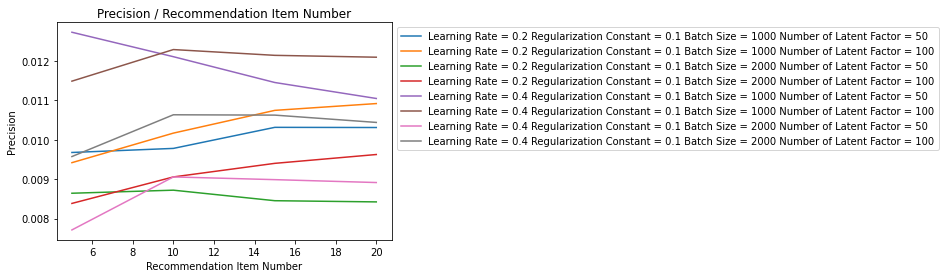

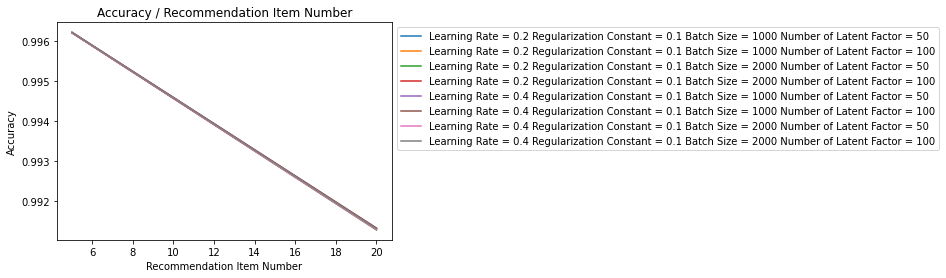

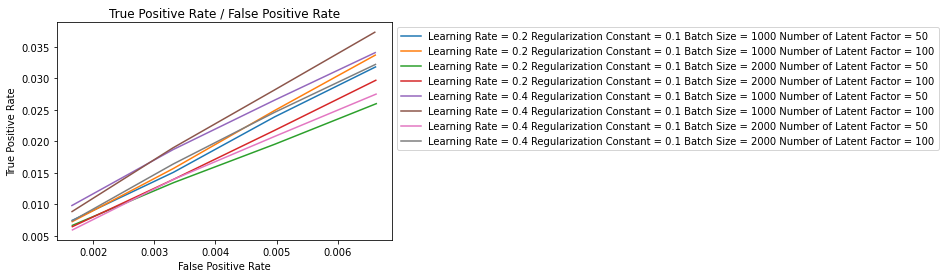

In [14]:
# validate model

evaluation_mode = 'validation'

validation_data_dictionary = DataHelper().load_data_dictionary(validation_data_url)

user_ids = validation_data_dictionary[data_group_by_user_id_dictionary_key][data_user_column_name].tolist()

n_best_recommendation_start = 5
n_best_recommendation_step = 5
n_best_recommendation_stop = 20 + 1

n_best_recommendations = list(range(n_best_recommendation_start, n_best_recommendation_stop, n_best_recommendation_step))

for bayseian_personalized_ranking_model in bayseian_personalized_ranking_models:
    bayseian_personalized_ranking_model.validation_data_dictionary = validation_data_dictionary

for bayseian_personalized_ranking_model in bayseian_personalized_ranking_models:
    true_positive_rates = []
    false_positive_rates = []
    precisions = []
    accuracys = []
    for n_best_recommendation in n_best_recommendations:
        recommendation_data_dictionary = bayseian_personalized_ranking_model.recommend(n_best_recommendation, evaluation_mode)
        true_positive_rate, false_positive_rate, precision, accuracy = ModelAnalyzerHelper().evaluate(bayseian_personalized_ranking_model, recommendation_data_dictionary, evaluation_mode)
        true_positive_rates.append(true_positive_rate)
        false_positive_rates.append(false_positive_rate)
        precisions.append(precision)
        accuracys.append(accuracy)
    bayseian_personalized_ranking_model.evaluation_dictionary = {
                                                                    recommendation_number_dictionary_key : n_best_recommendations,
                                                                    true_positive_rate_dictionary_key : true_positive_rates, 
                                                                    false_positive_rate_dictionary_key : false_positive_rates, 
                                                                    precision_dictionary_key : precisions,
                                                                    accuracy_dictionary_key : accuracys
                                                                }

for bayseian_personalized_ranking_model in bayseian_personalized_ranking_models:
    print('debug - bayseian_personalized_ranking_model.evaluation_dictionary:', bayseian_personalized_ranking_model.evaluation_dictionary, end='\n')

ModelAnalyzerHelper().plot_precision_chart(bayseian_personalized_ranking_models)
print('', end='\n')
ModelAnalyzerHelper().plot_accuracy_chart(bayseian_personalized_ranking_models)
print('', end='\n')
ModelAnalyzerHelper().plot_receiver_operating_characteristic_chart(bayseian_personalized_ranking_models)

In [15]:
# test model

evaluation_mode = 'testing'

testing_data_dictionary = DataHelper().load_data_dictionary(testing_data_url)

n_best_recommendation = 5

model_index = 0
bayseian_personalized_ranking_model = bayseian_personalized_ranking_models[model_index]

bayseian_personalized_ranking_model.testing_data_dictionary = testing_data_dictionary
recommendation_data_dictionary = bayseian_personalized_ranking_model.recommend(n_best_recommendation, evaluation_mode)
print('debug - recommendation_data_dictionary:', recommendation_data_dictionary, end='\n')

user_ids = testing_data_dictionary[data_group_by_user_id_dictionary_key][data_user_column_name].tolist()
user_id = np.random.choice(user_ids)
best_recommendition_item_ids = bayseian_personalized_ranking_model.recommend_user(user_id, n_best_recommendation)
print('debug - user_id:', user_id, 'best_recommendition_item_ids:', best_recommendition_item_ids, end='\n')

Streaming output truncated to the last 5000 lines.

debug - n_best_recommendation: 5 learning_rate: 0.2 regularization_constant: 0.1 n_batch: 1000 n_latent_factor: 50
debug - user_id: 2236 best_recommendition_item_ids: [1021, 321, 2966, 1475, 2274]

debug - n_best_recommendation: 5 learning_rate: 0.2 regularization_constant: 0.1 n_batch: 1000 n_latent_factor: 50
debug - user_id: 2237 best_recommendition_item_ids: [480, 705, 669, 1940, 325]

debug - n_best_recommendation: 5 learning_rate: 0.2 regularization_constant: 0.1 n_batch: 1000 n_latent_factor: 50
debug - user_id: 2238 best_recommendition_item_ids: [292, 2812, 2518, 2210, 2275]

debug - n_best_recommendation: 5 learning_rate: 0.2 regularization_constant: 0.1 n_batch: 1000 n_latent_factor: 50
debug - user_id: 2239 best_recommendition_item_ids: [196, 422, 292, 480, 217]

debug - n_best_recommendation: 5 learning_rate: 0.2 regularization_constant: 0.1 n_batch: 1000 n_latent_factor: 50
debug - user_id: 2240 best_recommendition_item_i